### PuLP

Objective Value: 105.0


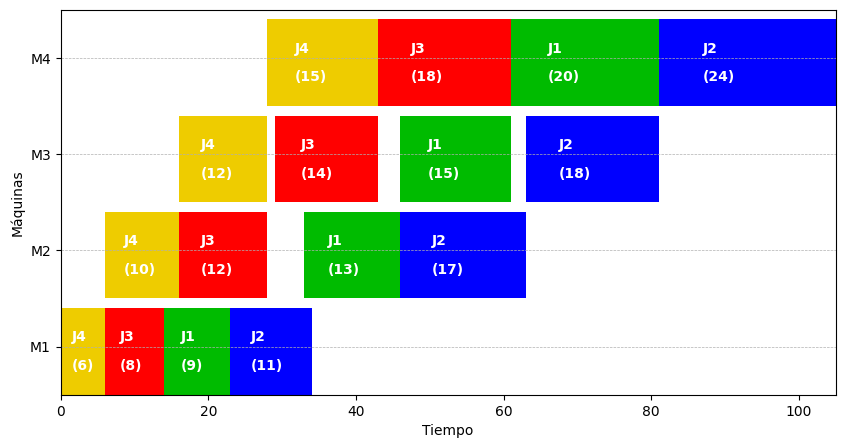

In [20]:
import pulp as lp
import numpy as np
import matplotlib.pyplot as plt

# Datos del problema
T = np.array([[9, 13, 15, 20],
              [11, 17, 18, 24],
              [8, 12, 14, 18],
              [6, 10, 12, 15]])

T = T.transpose()  # Transponer la matriz de tiempos para que las filas sean las máquinas y las columnas los trabajos

N = len(T[0])  # Número de trabajos (columnas)
M = len(T)  # Número de máquinas (filas)

# Crear el problema de LP
model_manne = lp.LpProblem("Manne_Model", lp.LpMinimize)

# Definir la constante P de penalización máxima
P = 100000

# Definir las variables de decisión
C = lp.LpVariable.dicts("C", (range(M), range(N)), lowBound=0, cat='Integer') # Tiempo de la tarea C_ij
D = lp.LpVariable.dicts("D", (range(N), range(N)), cat='Binary')
C_max = lp.LpVariable("C_max", lowBound=0, cat='Integer')

# Definir la función objetivo
model_manne += C_max

# Definir las restricciones
# (1)  El tiempo de inicio de la tarea i(columna i) en la primera máquina(fila 0) debe ser mayor o igual al tiempo de procesamiento de esa tarea en la primera máquina.
for i in range(N):
    model_manne += C[0][i] >= T[0][i]

# (2) el tiempo de procesamiento de la tarea i (columna i) en la máquina r(fila r) debe ser mayor o igual al tiempo de procesamiento de esa tarea en la máquina r−1.
for r in range(1, M):
    for i in range(N):
        model_manne += C[r][i] - C[r-1][i] >= T[r][i]

# (3) el tiempo de procesamiento de la tarea i (columna i) en la máquina r(fila r) debe ser mayor o igual al tiempo de procesamiento de la tarea k(columna k) en la misma máquina (fila r)
#considerando la penalización P*Dik
for r in range(M):
    for i in range(N):
        for k in range(i + 1, N):
            model_manne += C[r][i] - C[r][k] + P * D[i][k] >= T[r][i]

# (4) igual que (3), pero la penalización máxima debe ser menor o igual a  el tiempo de procesamiento de la tarea k (columna k) en la máquina r (fila r)
for r in range(M):
    for i in range(N):
        for k in range(i + 1, N):
            model_manne += C[r][i] - C[r][k] + P * D[i][k] <= P - T[r][k]

# (5) El tiempo total de finalización Cmax debe ser mayor o igual al tiempo de procesamiento de la tarea i(columna i) en la última máquina(M-1)
for i in range(N):
    model_manne += C_max >= C[M-1][i]

# Resolver el problema de LP
solution_manne = model_manne.solve()

# Imprimir la solución óptima
print("Objective Value:", lp.value(model_manne.objective))

# Carta Gannt
matriz = []
for r in range(M):
    maquina = []
    for i in range(N):
        maquina.append([int(lp.value(C[r][i]) - T[r][i]),int(lp.value(C[r][i]))])
    matriz.append(maquina)

fig, gantt = plt.subplots(figsize=(10, 5))
gantt.set_xlabel('Tiempo')
gantt.set_ylabel('Máquinas')
gantt.set_xlim(0, lp.value(model_manne.objective))
gantt.set_ylim(0, M * 10)
gantt.set_yticks(np.arange(5, M * 10, 10))
gantt.set_yticklabels(['M' + str(i) for i in range(1, M+1)])
gantt.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)
colores = ['#00BB00', 'blue', 'red', '#EECC00']

for r in range(M):
    for j in range(N):
        inicio = matriz[r][j][0]
        duracion = matriz[r][j][1] - matriz[r][j][0]
        gantt.broken_barh([(inicio, duracion)], ((r) * 10, 9), facecolors=colores[j])
        gantt.text(x=(inicio + duracion/4), y=((r) * 10 + 6), s='J'+str(j+1), va='center', color='white', fontweight='bold')
        gantt.text(x=(inicio + duracion/4), y=((r) * 10 + 3), s='('+str(duracion)+')', va='center', color='white', fontweight='bold') 

### CPLEX

Objective Value: 105.0
C_0_0 = 9.0
C_0_1 = 11.0
C_0_2 = 8.0
C_0_3 = 6.0
C_1_0 = 41.0
C_1_1 = 58.0
C_1_2 = 28.0
C_1_3 = 16.0
C_2_0 = 57.0
C_2_1 = 76.0
C_2_2 = 42.0
C_2_3 = 28.0
C_3_0 = 81.0
C_3_1 = 105.0
C_3_2 = 61.0
C_3_3 = 43.0
D_0_1 = 1.0
D_0_2 = 0
D_0_3 = 0
D_1_2 = 0
D_1_3 = 0
D_2_3 = 0
C_max = 105.0


C:\Users\valen\AppData\Local\Temp\ipykernel_20816\1324310958.py:100: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  legend_handles = [plt.Rectangle((0, 0), 1, 1, color=colors[i], edgecolor='black') for i in range(N)]


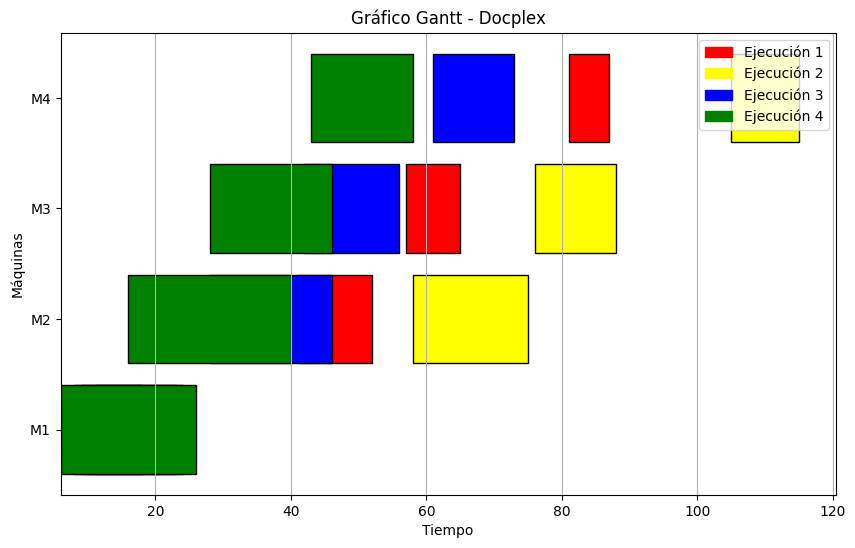

In [2]:
from docplex.mp.model import Model
import numpy as np
import matplotlib.pyplot as plt

# Datos del problema
T = np.array([[9, 13, 15, 20],
              [11, 17, 18, 24],
              [8, 12, 14, 18],
              [6, 10, 12, 15]])

N = len(T)  # Número de trabajos (filas)
M = len(T[0])  # Número de máquinas (columnas)

# El modelo está definido usando las máquinas como filas y los tiempos de ejecución como columnas
T = T.transpose()  # maquinas x trabajos

# Crear el modelo de CPLEX
model_cplex = Model(name="Manne_Model")

# Definir la constante P de penalización máxima
P = 100000

# Definir las variables de decisión
C = {(r, i): model_cplex.integer_var(name=f"C_{r}_{i}") for r in range(M) for i in range(N)}
D = {(i, k): model_cplex.binary_var(name=f"D_{i}_{k}") for i in range(N) for k in range(i + 1, N)}
C_max = model_cplex.integer_var(name="C_max")

# Definir la función objetivo
model_cplex.minimize(C_max)

# Definir las restricciones
# (1)  El tiempo de inicio de la tarea i (columna i) en la primera máquina (fila 0) debe ser mayor o igual al tiempo de procesamiento de esa tarea en la primera máquina.
for i in range(N):
    model_cplex.add_constraint(C[0, i] >= T[0, i])

# (2) el tiempo de procesamiento de la tarea i (columna i) en la máquina r (fila r) debe ser mayor o igual al tiempo de procesamiento de esa tarea en la máquina r−1.
for r in range(1, M):
    for i in range(N):
        model_cplex.add_constraint(C[r, i] - C[r - 1, i] >= T[r, i])

# (3) el tiempo de procesamiento de la tarea i (columna i) en la máquina r (fila r) debe ser mayor o igual al tiempo de procesamiento de la tarea k (columna k) en la misma máquina (fila r)
# considerando la penalización P*Dik
for r in range(1, M):
    for i in range(N):
        for k in range(i + 1, N):
            model_cplex.add_constraint(C[r, i] - C[r, k] + P * D[i, k] >= T[r, i])

# (4) igual que (3), pero la penalización máxima debe ser menor o igual a  el tiempo de procesamiento de la tarea k (columna k) en la máquina r (fila r)
for r in range(1, M):
    for i in range(N - 1):
        for k in range(i + 1, N):
            model_cplex.add_constraint(C[r, i] - C[r, k] + P * D[i, k] <= P - T[r, k])

# (5) El tiempo total de finalización Cmax debe ser mayor o igual al tiempo de procesamiento de la tarea i (columna i) en la última máquina(M-1)
for i in range(N):
    model_cplex.add_constraint(C_max >= C[M - 1, i])

# Resolver el problema con CPLEX
solution_cplex = model_cplex.solve()

# Imprimir la solución óptima
print("Objective Value:", model_cplex.objective_value)
for v in model_cplex.iter_variables():
    print(v.name, "=", v.solution_value)


# Carta Gannt

# Definir colores para cada ejecución
colors = ['red', 'yellow', 'blue', 'green']

# Duraciones de las tareas
durations = T.transpose()

# Nombres de las máquinas
machine_names = [f"M{i+1}" for i in range(M)][::-1]  # Invertir el orden de las máquinas

# Obtener los resultados
start_times_cplex = {(r, i): C[r, i].solution_value for r in range(M) for i in range(N)}

# Crear el gráfico Gantt
fig, ax = plt.subplots(figsize=(10, 6))

for i in range(M-1, -1, -1):  # Iterar en orden inverso
    for j in range(N):
        start = start_times_cplex[i, j]
        duration = T[j][i]
        ax.barh(machine_names[M - 1 - i], duration, left=start, color=colors[j], edgecolor='black')

ax.set_xlabel('Tiempo')
ax.set_ylabel('Máquinas')
ax.set_title('Gráfico Gantt - Docplex')

# Ajustar el formato del gráfico para mayor claridad
ax.invert_yaxis()
ax.xaxis.grid(True)

# Crear una leyenda personalizada para los colores de ejecución
legend_labels = [f'Ejecución {i+1}' for i in range(N)]
legend_handles = [plt.Rectangle((0, 0), 1, 1, color=colors[i], edgecolor='black') for i in range(N)]
ax.legend(legend_handles, legend_labels, loc='upper right')

plt.show()

### Gurobi

Restricted license - for non-production use only - expires 2024-10-28
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10210U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 56 rows, 33 columns and 144 nonzeros
Model fingerprint: 0xf70e175a
Variable types: 0 continuous, 33 integer (16 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e+00, 1e+05]
Found heuristic solution: objective 111.0000000
Presolve removed 8 rows and 14 columns
Presolve time: 0.00s
Presolved: 48 rows, 19 columns, 132 nonzeros
Variable types: 0 continuous, 19 integer (6 binary)

Root relaxation: objective 7.000000e+01, 6 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incum

C:\Users\valen\AppData\Local\Temp\ipykernel_17560\3057366105.py:100: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  legend_handles = [plt.Rectangle((0, 0), 1, 1, color=colors[i], edgecolor='black') for i in range(N)]


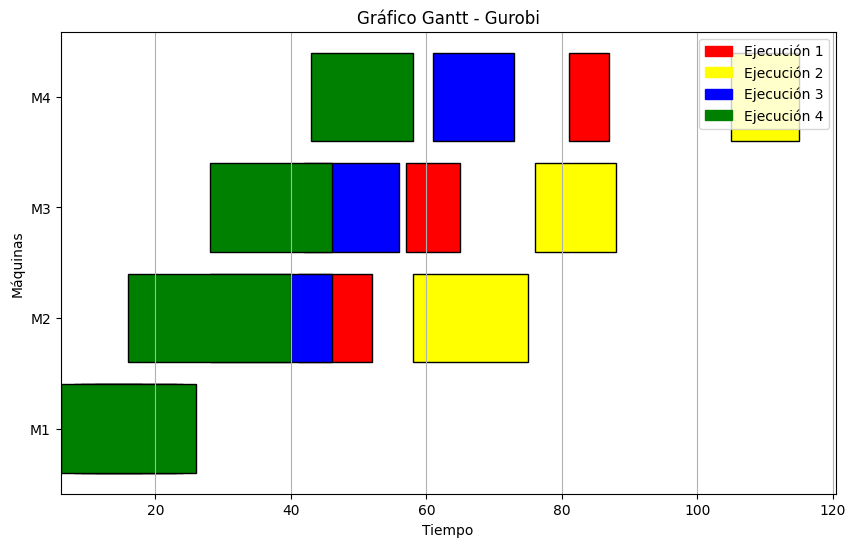

In [1]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import matplotlib.pyplot as plt

# Datos del problema
T = np.array([[9, 13, 15, 20],
              [11, 17, 18, 24],
              [8, 12, 14, 18],
              [6, 10, 12, 15]])

N = len(T)  # Número de trabajos (filas)
M = len(T[0])  # Número de máquinas (columnas)

# El modelo está definido usando las máquinas como filas y los tiempos de ejecución como columnas
T = T.transpose()  # maquinas x trabajos

# Crear el problema de LP
model_manne = gp.Model("Manne_Model")

# Definir la constante P de penalización máxima
P = 100000

# Definir las variables de decisión
C = model_manne.addVars(range(M), range(N), lb=0, vtype=GRB.INTEGER, name="C")
D = model_manne.addVars(range(N), range(N), vtype=GRB.BINARY, name="D")
C_max = model_manne.addVar(lb=0, vtype=GRB.INTEGER, name="C_max")

# Definir la función objetivo
model_manne.setObjective(C_max, sense=GRB.MINIMIZE)

# Definir las restricciones
# (1) El tiempo de inicio de la tarea i (columna i) en la primera máquina (fila 0) debe ser mayor o igual al tiempo de procesamiento de esa tarea en la primera máquina.
for i in range(N):
    model_manne.addConstr(C[0, i] >= T[0, i])

# (2) El tiempo de procesamiento de la tarea i (columna i) en la máquina r (fila r) debe ser mayor o igual al tiempo de procesamiento de esa tarea en la máquina r−1.
for r in range(1, M):
    for i in range(N):
        model_manne.addConstr(C[r, i] - C[r - 1, i] >= T[r, i])

# (3) El tiempo de procesamiento de la tarea i (columna i) en la máquina r (fila r) debe ser mayor o igual al tiempo de procesamiento de la tarea k (columna k) en la misma máquina (fila r)
# considerando la penalización P*Dik
for r in range(1, M):
    for i in range(N):
        for k in range(i + 1, N):
            model_manne.addConstr(C[r, i] - C[r, k] + P * D[i, k] >= T[r, i])

# (4) Igual que (3), pero la penalización máxima debe ser menor o igual a  el tiempo de procesamiento de la tarea k (columna k) en la máquina r (fila r)
for r in range(1, M):
    for i in range(N - 1):
        for k in range(i + 1, N):
            model_manne.addConstr(C[r, i] - C[r, k] + P * D[i, k] <= P - T[r, k])

# (5) El tiempo total de finalización Cmax debe ser mayor o igual al tiempo de procesamiento de la tarea i (columna i) en la última máquina (M-1)
for i in range(N):
    model_manne.addConstr(C_max >= C[M - 1, i])

# Resolver el problema de LP
model_manne.optimize()

# Imprimir la solución óptima
print("Objective Value:", model_manne.objVal)
for v in model_manne.getVars():
    print(v.varName, "=", v.x)


# Carta Gannt
# Definir colores para cada ejecución
colors = ['red', 'yellow', 'blue', 'green']

# Duraciones de las tareas
durations = T.transpose()

# Nombres de las máquinas
machine_names = [f"M{i+1}" for i in range(M)][::-1]  # Invertir el orden de las máquinas

# Obtener los resultados
start_times_gurobi = np.array([[C[m, n].x for n in range(N)] for m in range(M)])

# Crear el gráfico Gantt
fig, ax = plt.subplots(figsize=(10, 6))

for i in range(M):
    for j in range(N):
        start = start_times_gurobi[M - 1 - i][j]  # Corregir el orden de las máquinas
        duration = T[j][M - 1 - i]  # Corregir el orden de las máquinas
        ax.barh(machine_names[i], duration, left=start, color=colors[j], edgecolor='black')

ax.set_xlabel('Tiempo')
ax.set_ylabel('Máquinas')
ax.set_title('Gráfico Gantt - Gurobi')

# Ajustar el formato del gráfico para mayor claridad
ax.invert_yaxis()
ax.xaxis.grid(True)

# Crear una leyenda personalizada para los colores de ejecución
legend_labels = [f'Ejecución {i+1}' for i in range(N)]
legend_handles = [plt.Rectangle((0, 0), 1, 1, color=colors[i], edgecolor='black') for i in range(N)]
ax.legend(legend_handles, legend_labels, loc='upper right')

plt.show()